In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import PIL
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##**1.Without Regularization**

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_set = torchvision.datasets.FashionMNIST('data/MNIST',
                                   train=True,
                                   download=True,
                                   transform=transform,
                                   target_transform=None)

dev_set = torchvision.datasets.FashionMNIST('data/MNIST',
                                   train=False,
                                   download=True,
                                   transform=transform,
                                   target_transform=None)

train_loader = torch.utils.data.DataLoader(train_set,
                                    batch_size=64,
                                    shuffle=True)

dev_loader = torch.utils.data.DataLoader(dev_set,
                                    batch_size=64,
                                    shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/FashionMNIST/raw



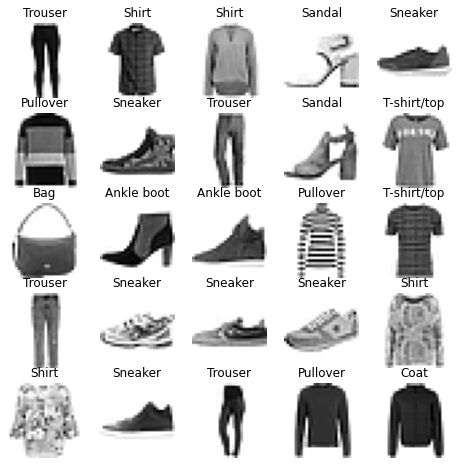

In [4]:
data_classes = train_set.classes
fig = plt.figure(figsize=(8, 8))
rows, cols = 5, 5
for i in range(1, rows*cols + 1):
  idx = torch.randint(0, len(train_set), size=(1,)).item()
  img, label = train_set[idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray_r')
  plt.title(data_classes[label])
  plt.axis(False)

In [ ]:
class NetMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    # input --> (64, 1, 28, 28)
    self.conv1 = nn.Conv2d(1, 32, 3)
    # input --> (64, 32, 26, 26)
    self.conv2 = nn.Conv2d(32, 64, 3)
    # input --> (64, 64, 24, 24)
    self.pool = nn.MaxPool2d(2)
    # input --> (64, 64, 12, 12)
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(64*12*12, 128)
    self.fc2 = nn.Linear(128, 10)
  
  def forward(self, x: torch.tensor) -> torch.tensor:
    out = F.relu(self.conv1(x))
    out = self.pool(F.relu(self.conv2(out)))
    out = self.flat(out)
    out = F.relu(self.fc1(out))
    return self.fc2(out)

model = NetMNIST().to(device)
print(model)

NetMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

def accuracy_fn(true, pred):
  correct = torch.eq(true, pred)
  return (torch.sum(correct)/len(true))*100

In [ ]:
from time import time

start = time()
epochs = 5
epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
  print(f"\nEpoch: {epoch + 1}\n--------")
  train_loss = dev_loss = train_acc = dev_acc = 0

  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = criterion(y_pred, y)
    accuracy = accuracy_fn(y, y_pred.argmax(dim=1))

    train_loss += loss
    train_acc += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
    if batch % 400 == 0 and batch != 0:
      print(f' batch: {batch} -- {batch*64} of {len(train_loader.dataset)} sample')

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  epoch_log.append(epoch)
  accuracy_log.append(train_acc)
  loss_log.append(train_loss)
  print(f'Train loss: {train_loss:.4f} -- Train accuracy: {train_acc:.4f}')

  model.eval()
  # with torch.inference_mode():
  with torch.no_grad():
    for X_dev, y_dev in dev_loader:
      X_dev, y_dev = X_dev.to(device), y_dev.to(device)
      y_pred_dev = model(X_dev)
      loss_dev = criterion(y_pred, y)
      accuracy_dev = accuracy_fn(y_dev, y_pred_dev.argmax(dim=1))

      dev_loss += loss_dev
      dev_acc += accuracy_dev

    dev_loss /= len(dev_loader)
    dev_acc /= len(dev_loader)
    print(f'Dev loss: {dev_loss:.4f} -- Dev accuracy: {dev_acc:.4f}\n')
    print(f'Time: {time() - start:.3f} seconds')



Epoch: 1
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.7520 -- Train accuracy: 73.2942
Dev loss: 0.2231 -- Dev accuracy: 80.5533

Time: 20.976 seconds

Epoch: 2
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.4885 -- Train accuracy: 82.0995
Dev loss: 0.5977 -- Dev accuracy: 82.3149

Time: 40.623 seconds

Epoch: 3
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.4316 -- Train accuracy: 84.4666
Dev loss: 0.4595 -- Dev accuracy: 84.0565

Time: 58.779 seconds

Epoch: 4
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.3927 -- Train accuracy: 85.7376
Dev loss: 0.5507 -- Dev accuracy: 85.7982

Time: 80.747 seconds

Epoch: 5
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.3633 -- Train accuracy: 86.9303
Dev loss: 0.3136 -- Dev accuracy: 86.7834

Time: 

##**2.With Regularization**

In [5]:
transformer = {'dev': transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.5, ), (0.5))
               ]),
               'train': transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.5, ), (0.5)),
                   transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5), 
                   transforms.ColorJitter(hue = .05, saturation = .05),
                   transforms.RandomHorizontalFlip(),
                   transforms.RandomRotation(15, interpolation = PIL.Image.BILINEAR),
                   transforms.Grayscale(num_output_channels = 1),
               ])
}
train = torchvision.datasets.FashionMNIST('torchFasionMNIST',
                                         train=True,
                                         transform=transformer['train'],
                                         download=True)

dev = torchvision.datasets.FashionMNIST('torchFasionMNIST',
                                         train=False,
                                         transform=transformer['dev'],
                                         download=True)

train_loader= torch.utils.data.DataLoader(train, 64, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev, 64)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:1303: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting torchFasionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to torchFasionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting torchFasionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to torchFasionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting torchFasionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to torchFasionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting torchFasionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to torchFasionMNIST/FashionMNIST/raw



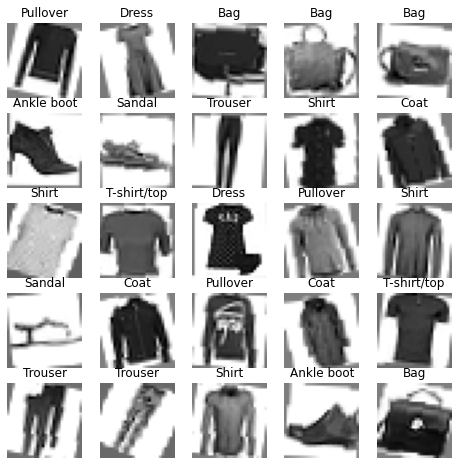

In [8]:
data_classes = train_set.classes
fig = plt.figure(figsize=(8, 8))
rows, cols = 5, 5
for i in range(1, rows*cols + 1):
  idx = torch.randint(0, len(train_set), size=(1,)).item()
  img, label = train[idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray_r')
  plt.title(data_classes[label])
  plt.axis(False)

In [9]:
class NetFashionMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    # input --> (64, 1, 28, 28)
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.bn1 = nn.BatchNorm2d(32)
    # input --> (64, 32, 26, 26)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.bn2 = nn.BatchNorm2d(64)
    # input --> (64, 64, 24, 24)
    self.pool = nn.MaxPool2d(2)
    # input --> (64, 64, 12, 12)
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(64*12*12, 128)
    self.fc2 = nn.Linear(128, 10)
    self.drop = nn.Dropout(0.2)
  
  def forward(self, x: torch.tensor) -> torch.tensor:
    out = self.bn1(self.conv1(x))
    out = F.relu(out)
    out = self.bn2(self.conv2(out))
    out = self.drop(out)
    out = self.pool(F.relu(out))
    out = self.flat(out)
    out = F.relu(self.fc1(out))
    return self.fc2(out)

model_reg = NetFashionMNIST().to(device)

In [10]:
x = torch.rand((1, 1, 28, 28)).to(device)
model_reg(x)

tensor([[ 0.3016, -0.5209,  0.0186, -0.8736,  0.0855,  0.0893,  0.9138,  0.0170,
         -0.5209,  0.1002]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [11]:
model_reg.state_dict

<bound method Module.state_dict of NetFashionMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)>

In [14]:
optimizer = torch.optim.SGD(model_reg.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.001)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

def accuracy_fn(true, pred):
  correct = torch.eq(true, pred)
  return (torch.sum(correct)/len(true))*100

In [15]:
from time import time

start = time()
epochs = 5
epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
  print(f"\nEpoch: {epoch + 1}\n--------")
  train_loss = dev_loss = train_acc = dev_acc = 0

  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model_reg(X)
    loss = criterion(y_pred, y)
    accuracy = accuracy_fn(y, y_pred.argmax(dim=1))

    train_loss += loss
    train_acc += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
    if batch % 400 == 0 and batch != 0:
      print(f' batch: {batch} -- {batch*64} of {len(train_loader.dataset)} sample')

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  epoch_log.append(epoch)
  accuracy_log.append(train_acc)
  loss_log.append(train_loss)
  print(f'Train loss: {train_loss:.4f} -- Train accuracy: {train_acc:.4f}')

  model_reg.eval()
  # with torch.inference_mode():
  with torch.no_grad():
    for X_dev, y_dev in dev_loader:
      X_dev, y_dev = X_dev.to(device), y_dev.to(device)
      y_pred_dev = model_reg(X_dev)
      loss_dev = criterion(y_pred, y)
      accuracy_dev = accuracy_fn(y_dev, y_pred_dev.argmax(dim=1))

      dev_loss += loss_dev
      dev_acc += accuracy_dev

    dev_loss /= len(dev_loader)
    dev_acc /= len(dev_loader)
    print(f'Dev loss: {dev_loss:.4f} -- Dev accuracy: {dev_acc:.4f}\n')
    print(f'Time: {time() - start:.3f} seconds')



Epoch: 1
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 1.3111 -- Train accuracy: 57.2112
Dev loss: 1.0824 -- Dev accuracy: 66.2221

Time: 88.366 seconds

Epoch: 2
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 1.0058 -- Train accuracy: 64.4390
Dev loss: 1.1311 -- Dev accuracy: 67.5159

Time: 165.725 seconds

Epoch: 3
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 1.0068 -- Train accuracy: 64.2108
Dev loss: 1.0788 -- Dev accuracy: 65.7544

Time: 243.536 seconds

Epoch: 4
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 1.0023 -- Train accuracy: 64.4789
Dev loss: 1.0117 -- Dev accuracy: 66.3117

Time: 322.919 seconds

Epoch: 5
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.9986 -- Train accuracy: 64.5739
Dev loss: 0.7986 -- Dev accuracy: 65.8937

Tim

In [ ]:
PATH = "FashionMNIST_ModelTorch_no_Regularization.pt"
torch.save(model, PATH)

In [ ]:
PATH = "FashionMNIST_ModelTorch_RegularizationWeightDecay.pt"
torch.save(model_reg, PATH)

In [16]:
print("Without Regularization:\nTrain loss: 0.3927 -- Train accuracy: 85.7376 - Dev loss: 0.5507 -- Dev accuracy: 85.7982\n---------------")
print("With Regularization but not weight decay:\nTrain loss: 0.3579 -- Train accuracy: 86.7821 - Dev loss: 0.3346 -- Dev accuracy: 88.3459")
print("With Regularization weight decay = 0.001:\nTrain loss: 0.3620 -- Train accuracy: 86.7088 - Dev loss: 0.1366 -- Dev accuracy: 88.4554")

Without Regularization:
Train loss: 0.3927 -- Train accuracy: 85.7376 - Dev loss: 0.5507 -- Dev accuracy: 85.7982
---------------
With Regularization but not weight decay:
Train loss: 0.3579 -- Train accuracy: 86.7821 - Dev loss: 0.3346 -- Dev accuracy: 88.3459
With Regularization weight decay = 0.001:
Train loss: 0.3620 -- Train accuracy: 86.7088 - Dev loss: 0.1366 -- Dev accuracy: 88.4554
